In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

data_dir = "\\".join(os.getcwd().split("\\")[:-1]) + "\\Dataset"

In [42]:
data_import = pd.read_excel(data_dir + "\\PCL5_df.xlsx")

if data_import.shape[1] == 1:
    df = pd.DataFrame([list(data_import.applymap(lambda s: s.split(";")).values)[i][0]
                       for i in range(len(data_import))])
    df.columns = data_import.columns[0].split(";")
    
    for c in df.columns:
        if "PCL" in c:
            df[c] = df[c].astype(int)
    
else:
    df = data_import.copy()

In [115]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV

In [54]:
X = df.drop("CONDITION", axis = 1)
y = df["CONDITION"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .7,
                                                    random_state = 42, shuffle = True)

### Logistic regression with LASSO

In [113]:
lr = LogisticRegressionCV(Cs = 50, penalty = "l1", random_state = 42,
                          n_jobs = -1, solver = "saga", max_iter = 1e3)

lr.fit(X_train, y_train)

print(classification_report(y_test, lr.predict(X_test)))

              precision    recall  f1-score   support

           D       0.75      0.81      0.78        58
           H       0.81      0.75      0.78        63

    accuracy                           0.78       121
   macro avg       0.78      0.78      0.78       121
weighted avg       0.78      0.78      0.78       121



PCL2    -0.033739
PCL5    -0.341259
PCL14   -0.025878
Name: 0, dtype: float64


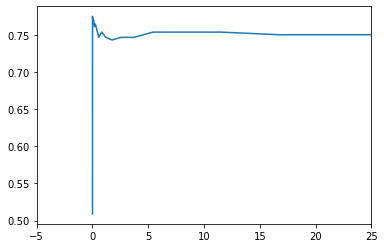

In [114]:
important_features = pd.DataFrame(dict(zip(list(X.columns), lr.coef_[0])),
                                  index = range(len(X.columns))).loc[0]

print(important_features[important_features !=  0])

plt.plot(lr.Cs_, lr.scores_["H"].mean(axis = 0))
plt.xlim(-5, 25)
plt.show()

## Decision Tree

In [119]:
tree = DecisionTreeClassifier(random_state = 42, criterion = "entropy")
tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

   Feature Importance
1     PCL2     0.3449
11   PCL12   0.121468
4     PCL5   0.061624
5     PCL6   0.050745
13   PCL14   0.047614


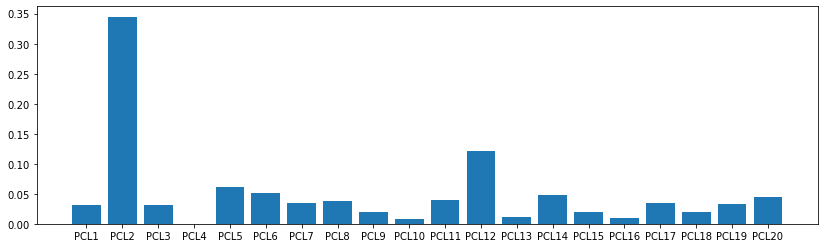

In [132]:
print(pd.DataFrame(np.c_[X.columns, tree.feature_importances_],
                   columns = ["Feature", "Importance"]).sort_values("Importance", ascending = False).head())

plt.figure(figsize = (14, 4))
plt.bar(x = X.columns, height = tree.feature_importances_)
plt.show()